# Import Package

In [124]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import shapefile as shp
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score

# Load Dataset 

In [2]:
df = pd.read_csv('churn.csv')
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


# Data Describing 

## Data Type 

In [4]:
numericals = df.select_dtypes(exclude = 'object')
non_numericals = df.select_dtypes(include = 'object') 

print('There is ', numericals.shape[1], 'Numerical (float atau int)')
print('There is', non_numericals.shape[1], 'Categorical (str)')

There is  4 Numerical (float atau int)
There is 8 Categorical (str)


## Missing Value 

In [5]:
df.isna().sum()

customerID           9
Gender              16
SeniorCitizen       12
Partner             16
Dependents          19
Tenure              17
Contract            13
PaperlessBilling    13
PaymentMethod       11
MonthlyCharges      10
TotalCharges         0
Churn                0
dtype: int64

In [6]:
data_null = df.isnull().sum().reset_index()
data_null.columns = ['feature','missing_value']
data_null['percentage'] = round((data_null['missing_value']/len(df))*100,2)
data_null = data_null.sort_values('percentage', ascending=False).reset_index(drop=True)
data_null = data_null[data_null['percentage']>0]
data_null

,feature,missing_value,percentage
0,Dependents,19,0.27
1,Tenure,17,0.24
2,Gender,16,0.23
3,Partner,16,0.23
4,Contract,13,0.18
5,PaperlessBilling,13,0.18
6,SeniorCitizen,12,0.17
7,PaymentMethod,11,0.16
8,MonthlyCharges,10,0.14
9,customerID,9,0.13


There is some missing value on dataset, We will handle missing value later 

## Duplicated Data 

In [7]:
df.duplicated().sum()

14

In [8]:
df[df.duplicated(keep=False)].sort_values('customerID').head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7039,2236-HILPA,Male,0.0,Yes,Yes,62.0,Two year,No,Credit card (automatic),20.65,1218.45,No
5915,2236-HILPA,Male,0.0,Yes,Yes,62.0,Two year,No,Credit card (automatic),20.65,1218.45,No
6567,2342-CKIAO,Female,0.0,No,No,2.0,Month-to-month,No,Mailed check,20.30,41.20,No
7040,2342-CKIAO,Female,0.0,No,No,2.0,Month-to-month,No,Mailed check,20.30,41.20,No
7032,2905-KFQUV,Female,0.0,Yes,No,2.0,Month-to-month,Yes,Credit card (automatic),70.40,154.80,No


### Drop Duplicated Rows

In [9]:
df = df.drop_duplicates()

In [10]:
df.duplicated().sum()

0

There is no more duplicated data 

# EDA 

Data Selecting 

In [11]:
nums = df.select_dtypes(exclude = 'object')
cats = df.select_dtypes(include = 'object')

## Statistical Summary

In [12]:
nums.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges
count,7020.000000,7015.000000,7022.000000,7032.000000
mean,0.162251,32.418247,64.822842,2283.300441
std,0.368707,24.552304,30.073445,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.662500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.887500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


1. Overall the maximum and minimum value is make sense 
2. SeniorCitizen contain boolean/binary value (0,1)
3. Mean ~ Median value on all data somehow show skewed, we will check again in analysis 

In [13]:
cats.describe()

,customerID,Gender,Partner,Dependents,Contract,PaperlessBilling,PaymentMethod,Churn
count,7023,7017,7016,7013,7019,7019,7021,7032
unique,7023,2,2,2,3,2,4,2
top,7590-VHVEG,Male,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3545,3630,4919,3866,4159,2361,5163


1. Gender, Partner, Dependents, PaperlessBilling, Churn contaion boolean value 
2. Customer gender mostly is Male
3. Customer mostly use Month to month contract 
4. Customer mostly use Paperless billing 

## Univariate Analysis 

### How is the distribution of customer gender?

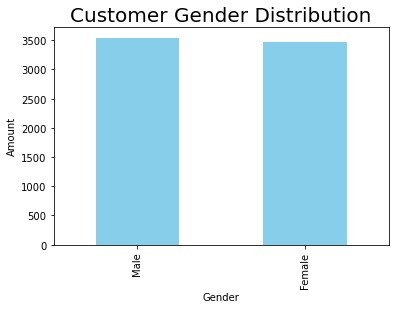

In [14]:
df['Gender'].value_counts().plot(kind='bar', color = 'skyblue')
plt.xlabel('Gender')
plt.ylabel('Amount')
plt.title('Customer Gender Distribution', fontsize = 20)
plt.show()

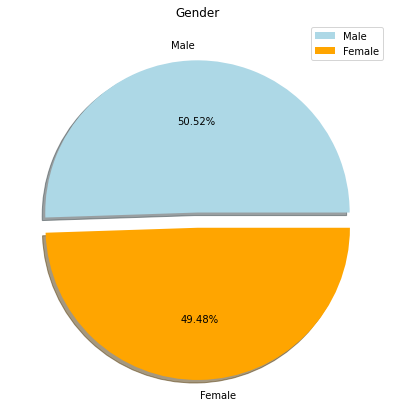

In [15]:
# Visualization on customers gender's percentage

labels = ['Male', 'Female']
size = df['Gender'].value_counts()
colors = ['lightblue', 'orange']
explode = [0, 0.1]

# Plot pie chart
plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender')
plt.axis('off')
plt.legend()
plt.show()

Customer gender distribution only has a slight difference, about a half of the customers in our data set are male while the other hald are female.

### What types of contracts are most widely used by customers?

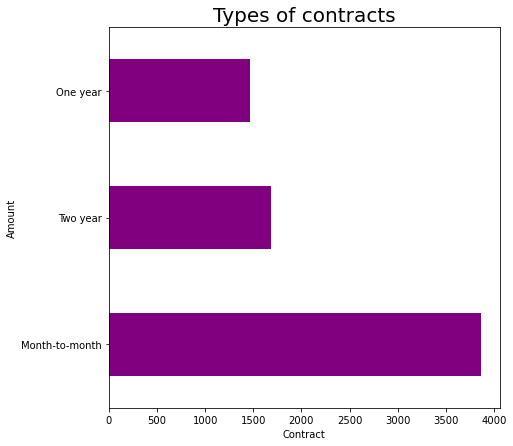

In [16]:
df['Contract'].value_counts().plot(kind='barh', color = 'purple')
plt.xlabel('Contract')
plt.ylabel('Amount')
plt.title('Types of contracts', fontsize = 20)
plt.show()

There is 3 types of contract, the most used contract by customer is month-to-month contract followed by two years contract, and one year contract 

### Boolean Data Distribution 

C:\Users\nadir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nadir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nadir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PaperlessBilling', ylabel='count'>

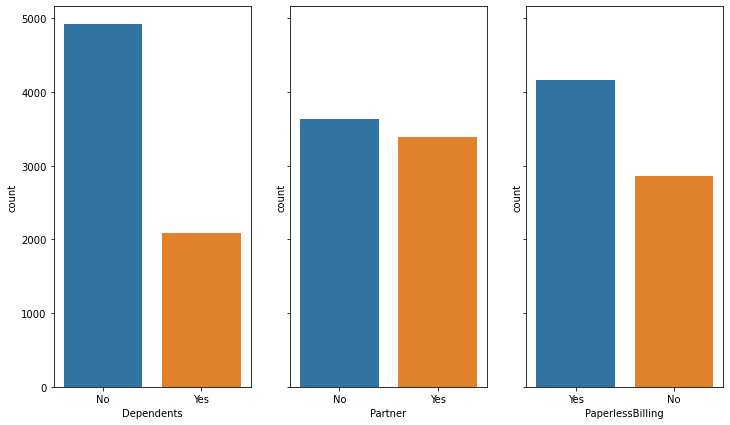

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
sns.countplot("Dependents", data=df, ax=axes[0])
sns.countplot("Partner", data=df, ax=axes[1])
sns.countplot("PaperlessBilling", data=df, ax=axes[2])

1. Dependents Status : There is a significant differences between cusmoter with dependents and customer without dependents. Where only around 30% of the total customers have dependent.
2. Partner Status : There is a slight differences about 40% - 50% between customer with partner and customer without partner
3. Paperless Billing : About 60% - 70% of the customers use paperless billing 

### What is the highest total charges?

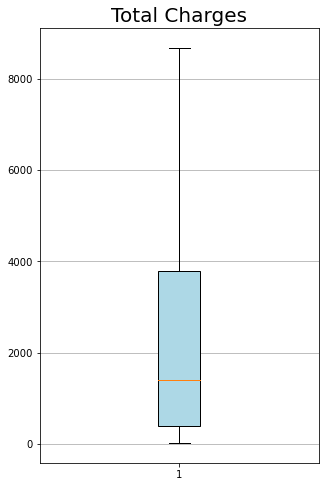

In [18]:
fig = plt.figure(figsize=(5,8))
plt.boxplot(df['TotalCharges'], patch_artist=True, boxprops={'facecolor': 'lightblue'})
plt.title('Total Charges',fontsize=20)
plt.grid(axis='y')
plt.show()

The highest amount of customers charges is more than 8000

### What payment methods are most used by customers?

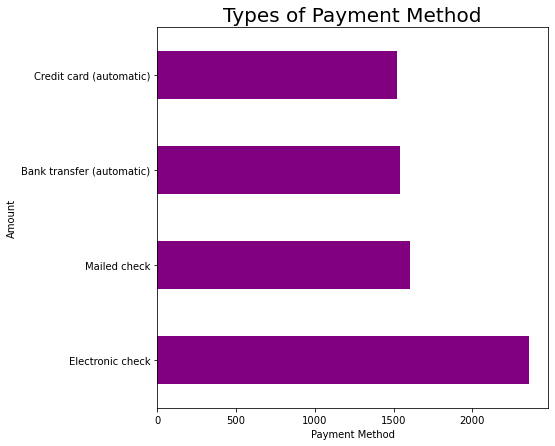

In [19]:
df['PaymentMethod'].value_counts().plot(kind='barh', color = 'purple')
plt.xlabel('Payment Method')
plt.ylabel('Amount')
plt.title('Types of Payment Method', fontsize = 20)
plt.show()

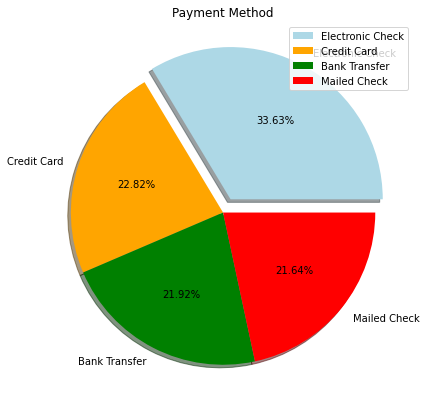

In [20]:
labels = ['Electronic Check','Credit Card', 'Bank Transfer', 'Mailed Check']
size = df['PaymentMethod'].value_counts()
colors = ['lightblue', 'orange', 'green','red']
explode = [0.1, 0, 0, 0]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Payment Method')
plt.axis('off')
plt.legend()
plt.show()

Payment method distributed pretty well, while electronic check have a slightly bigger count.

### What is the churn disribution?

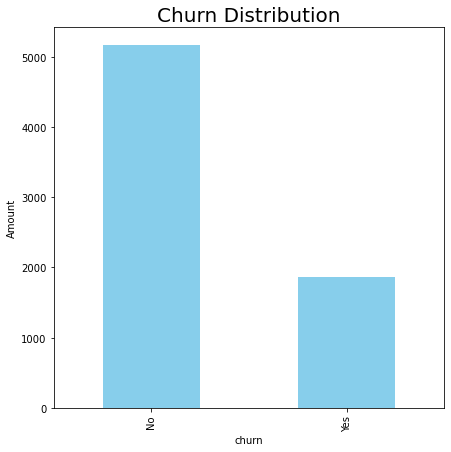

In [21]:
plots = df['Churn'].value_counts().plot(kind='bar', color = 'skyblue')
size = df['Churn'].value_counts()
plt.xlabel('churn')
plt.ylabel('Amount')
plt.title('Churn Distribution', fontsize = 20)
plt.show()

Around 70 percent customer not churned. The dataset showed skewed.

## Bivariate Analysis 

### How does Charges affect churn?

In [22]:
charges = ['Tenure', 'MonthlyCharges', 'TotalCharges']

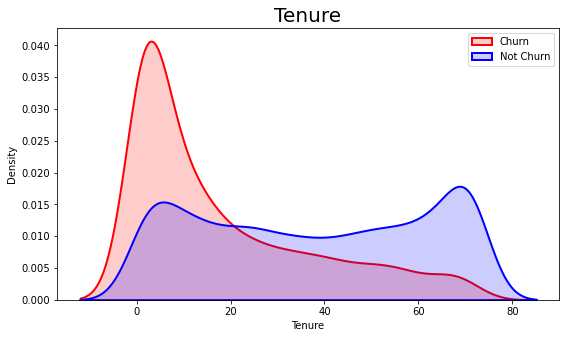

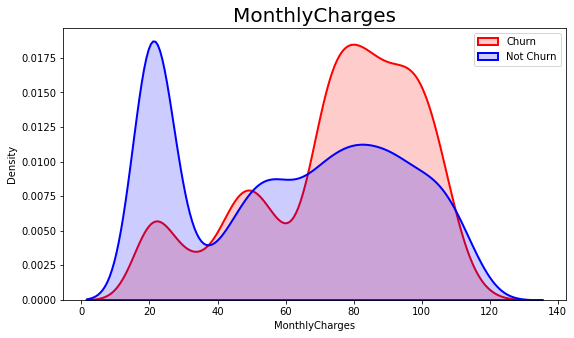

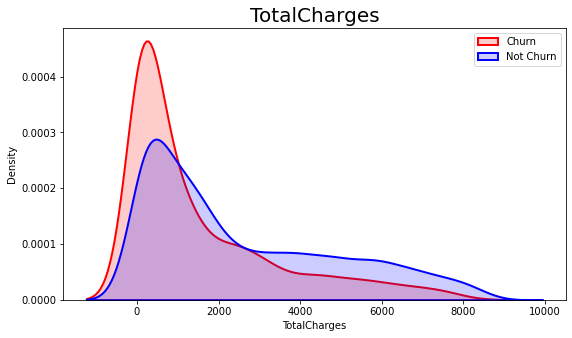

In [23]:
for col in charges:
    fig = plt.figure(figsize=(9, 5))
    fig.set_facecolor('white')

    ax = sns.kdeplot(data=df, x=(df[col][df['Churn'] == 'Yes']), shade=True, alpha=0.2, linewidth=2, color='red')
    ax = sns.kdeplot(data=df, x=(df[col][df['Churn'] == 'No']), shade=True, alpha=0.2, linewidth=2, color='blue')
    
    ax.set_title(col, fontsize=20)
    ax.legend(['Churn', 'Not Churn'], loc='upper right')
    plt.show()

- customer who churned tend to have tenure less than 20 
- customer with higher MonthlyChanges tend to churned, while customer with lower MonthlyCharges tend to stayed
- There's slightly higher density on higher TotalCharges on customer who not churn, but still mostly on lower TotalCharges.

### What is the relationship between MonthlyCharges and TotalCharges?

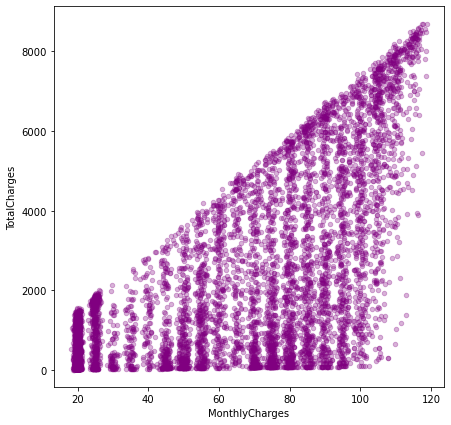

In [24]:
fig = df[['MonthlyCharges', 'TotalCharges']].plot.scatter(x='MonthlyCharges', y='TotalCharges', c='purple', alpha=0.3)
fig.set_facecolor('white')
plt.show()

there are linear relationship, where bigger the Monthly Charges, bigger the Total Charges, which was normal.

### How does Payment Method affect churn?

In [25]:
def fig_countplot_yn(df, col):
    fig = plt.figure(figsize=(9,6))
    fig.set_facecolor('white')
    ax = sns.countplot(data=df, x=col, hue='Churn', palette='flare')
    
    # percentage
    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]

    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.1%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.1%}'.format(height_r/total), ha="center")

    plt.show()

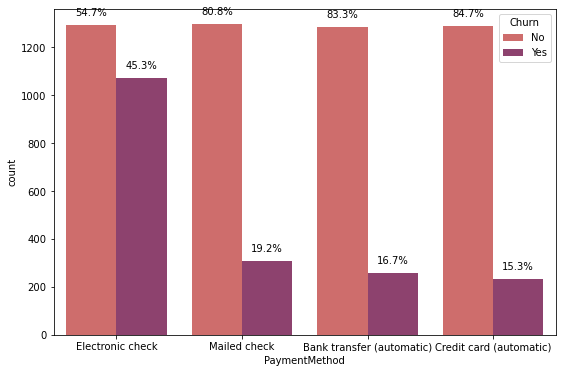

In [26]:
fig_countplot_yn(df, 'PaymentMethod')

yet being slightly larger count than other, electronic check has biggest churn rate of 45,3% while other has only less than 20% churn rate.

### How does Paperless Billing affect churn?

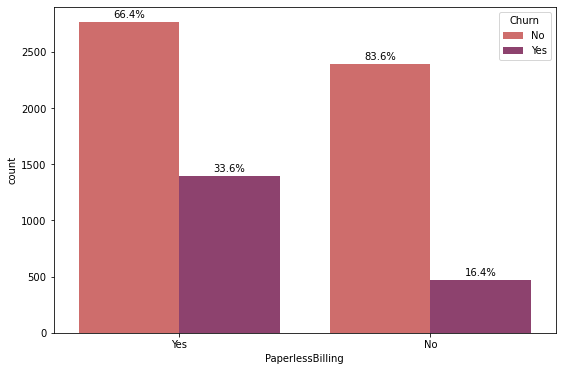

In [27]:
fig_countplot_yn(df, 'PaperlessBilling')

Customer majority use Paperless Billing, yet custemer who use Paperless Billing still have a highest rate to chured.

### How does Contact Method affect churn?

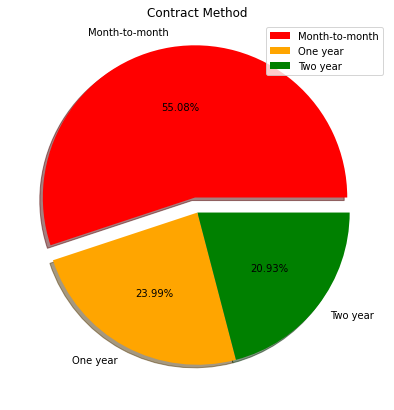

In [28]:
labels = ['Month-to-month', 'One year', 'Two year']
size = df['Contract'].value_counts()
colors = ['red', 'orange', 'green']
explode = [0.1, 0, 0]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Contract Method')
plt.axis('off')
plt.legend()
plt.show()

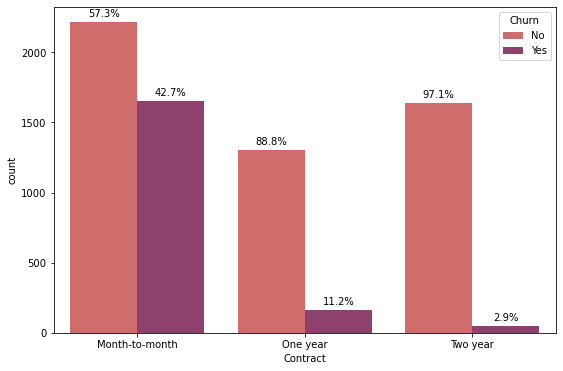

In [29]:
fig_countplot_yn(df, 'Contract')

month-to-month contract being a majority, and with the highest churn rate od 42,7% meanwhile one year contract has 11.3% churn rate and two year only 2,8% churn rate. that's mean loyal customer tend to make contract with longer period.

### How does Gender affect churn?

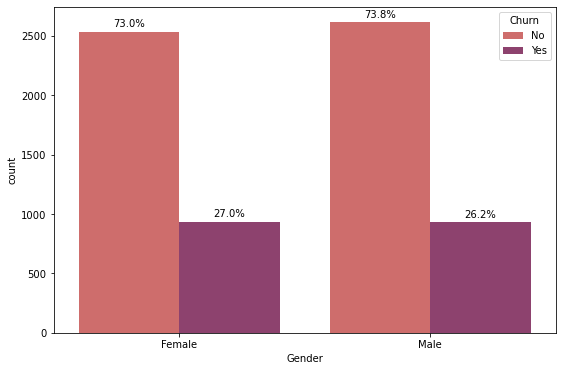

In [30]:
fig_countplot_yn(df, 'Gender')

Since Gender have a slight difference, the churn ratio also similar, this means gender not really affect to churn.

### How does Senior Citizen status affect churn?

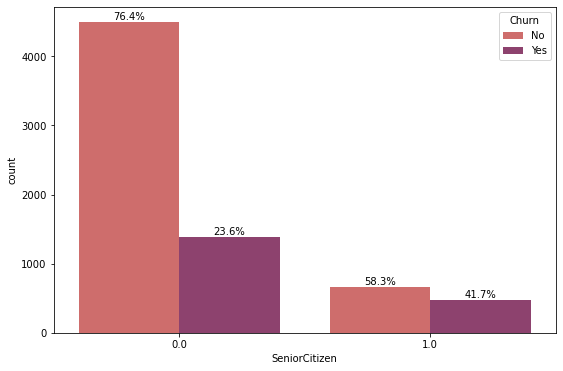

In [31]:
fig_countplot_yn(df, 'SeniorCitizen')

most of customer wasn't a senior citizen. however, senior citizen has more churn rate then customer who are not a senior citizen.

### How does Partner affect churn?

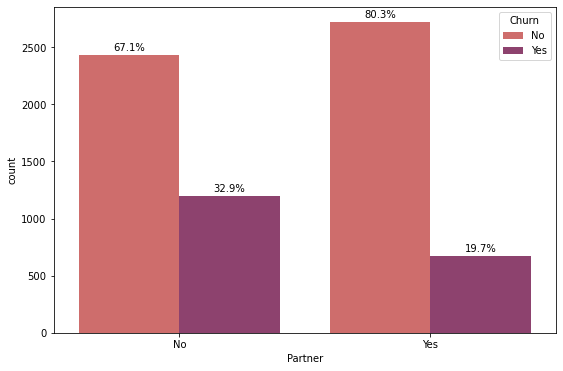

In [32]:
fig_countplot_yn(df, 'Partner')

customer who has partner count is more than customer without partner. While customer who don't has partner show slightly higher churn rate.

### How does Dependents affect churn?

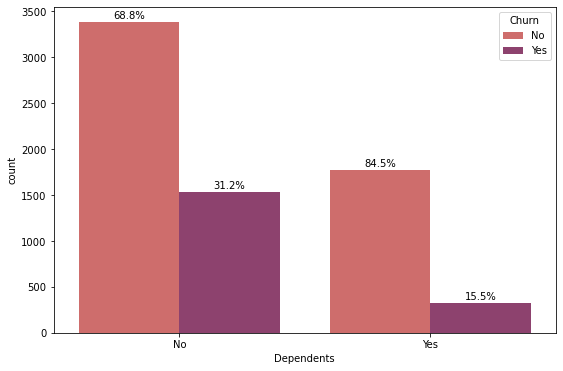

In [33]:
fig_countplot_yn(df, 'Dependents')

most customer doesn't have dependents. customer who has dependents shows lower churn rate than customer who don't.

### How is the dataset correlation status? 

<AxesSubplot:>

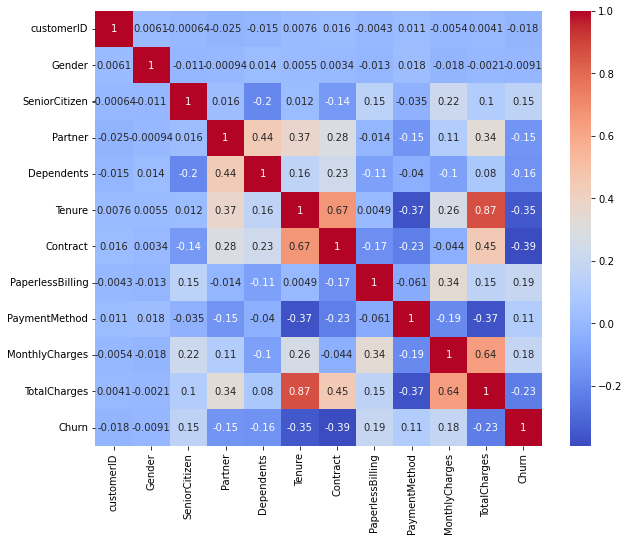

In [34]:
df_copy = df.copy()

# temporary convert y/n categorical to 0 or 1
cat = ['Churn', 'Partner', 'Dependents', 'PaperlessBilling']
for i in cat:
    df_copy[i].replace(to_replace='Yes', value=1, inplace=True)
    df_copy[i].replace(to_replace='No', value=0, inplace=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_copy = df_copy.apply(LabelEncoder().fit_transform)

fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('white')

feature_corr = df_copy.corr()
sns.heatmap(feature_corr, annot=True, cmap='coolwarm')

we can see that the most positive correlated with churn is PaperlessBilling, MonthlyCharges, and SeniorCitizen. and the most negatively correlated with churn is Contract, tenure, and OnlineSecurity. 

# Data Preprocessing 

## Data Cleaning 

### Missing value handling 

#### Customer ID 

In [35]:
# We will drop customer ID feature
df = df.drop(['customerID'], axis=1)

#### Other Features

Since the missing value is less than 5% we will drop the missing value 

In [36]:
df = df.dropna(axis=0, how='any')

In [91]:
df.isnull().sum()

Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

there is no more missing value on dataset 

### Outliers Handling 

In [38]:
features = list(df)[:-1]

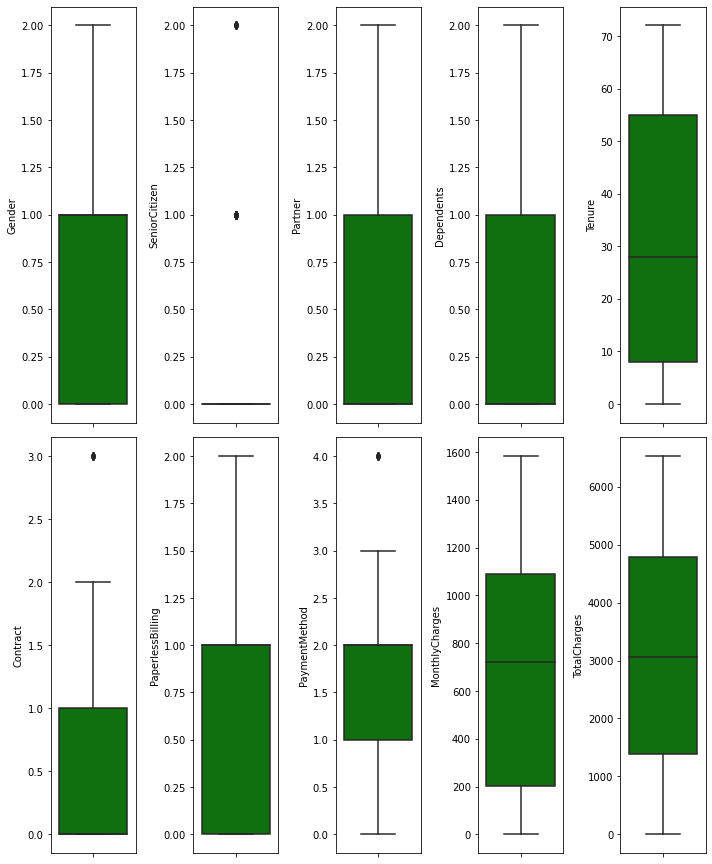

In [39]:
plt.figure(figsize = (10,30))
for i in range (0, len(features)): 
    plt.subplot(5,5, i +1 )
    sns.boxplot(y=features[i], data=df_copy,color = 'green')
    plt.tight_layout()

there is no outliers on dataset 

## Features Selecting 

Since we know the features that have affect to Churn we will choose the features

In [40]:
feat = ['Churn', 'Contract', 'Tenure', 'TotalCharges', 'PaperlessBilling', 'MonthlyCharges', 'Dependents', 'SeniorCitizen', 'Partner', 'PaymentMethod']
new_df = df[feat]
new_df.head()

,Churn,Contract,Tenure,TotalCharges,PaperlessBilling,MonthlyCharges,Dependents,SeniorCitizen,Partner,PaymentMethod
1,No,One year,34.0,1889.50,No,56.95,No,0.0,No,Mailed check
2,Yes,Month-to-month,2.0,108.15,Yes,53.85,No,0.0,No,Mailed check
3,No,One year,45.0,1840.75,No,42.30,No,0.0,No,Bank transfer (automatic)
4,Yes,Month-to-month,2.0,151.65,Yes,70.70,No,0.0,No,Electronic check
5,Yes,Month-to-month,8.0,820.50,Yes,99.65,No,0.0,No,Electronic check


## Data Encoding 

In [41]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6907 entries, 1 to 7031
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             6907 non-null   object 
 1   Contract          6907 non-null   object 
 2   Tenure            6907 non-null   float64
 3   TotalCharges      6907 non-null   float64
 4   PaperlessBilling  6907 non-null   object 
 5   MonthlyCharges    6907 non-null   float64
 6   Dependents        6907 non-null   object 
 7   SeniorCitizen     6907 non-null   float64
 8   Partner           6907 non-null   object 
 9   PaymentMethod     6907 non-null   object 
dtypes: float64(4), object(6)
memory usage: 593.6+ KB


In [42]:
# encode categorical feature

# encode yes to 1 and no to 0
cat = ['Churn', 'Partner', 'Dependents', 'PaperlessBilling']
for i in cat:
    new_df[i].replace(to_replace='Yes', value=1, inplace=True)
    new_df[i].replace(to_replace='No', value=0, inplace=True)

# label encode rest of categorical data
from sklearn.preprocessing import LabelEncoder
new_df = new_df.apply(LabelEncoder().fit_transform)

C:\Users\nadir\AppData\Local\Temp\ipykernel_12244\3098522791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[i].replace(to_replace='Yes', value=1, inplace=True)
C:\Users\nadir\AppData\Local\Temp\ipykernel_12244\3098522791.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[i].replace(to_replace='No', value=0, inplace=True)


In [43]:
new_df.head()

,Churn,Contract,Tenure,TotalCharges,PaperlessBilling,MonthlyCharges,Dependents,SeniorCitizen,Partner,PaymentMethod
1,0,1,33,3558,0,494,0,0,0,3
2,1,0,1,528,1,432,0,0,0,3
3,0,1,44,3505,0,264,0,0,0,0
4,1,0,1,662,1,724,0,0,0,2
5,1,0,7,2139,1,1266,0,0,0,2


## Spliting Data 

In [44]:
# split train test
from sklearn.model_selection import train_test_split

feature = new_df.drop(columns='Churn')
target = new_df[['Churn']]

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.20, random_state=42)

## Multicollinearity Handling 

In [45]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,Contract,2.240626
2,Tenure,13.065374
3,TotalCharges,16.599554
4,PaperlessBilling,1.179921
5,MonthlyCharges,4.350438
6,Dependents,1.375421
7,SeniorCitizen,1.121783
8,Partner,1.465336
9,PaymentMethod,1.178165


There are several features with high VIF scores:

- Tenure
- TotalCharges

And a moderate VIF score: 
- MonthlyCharges

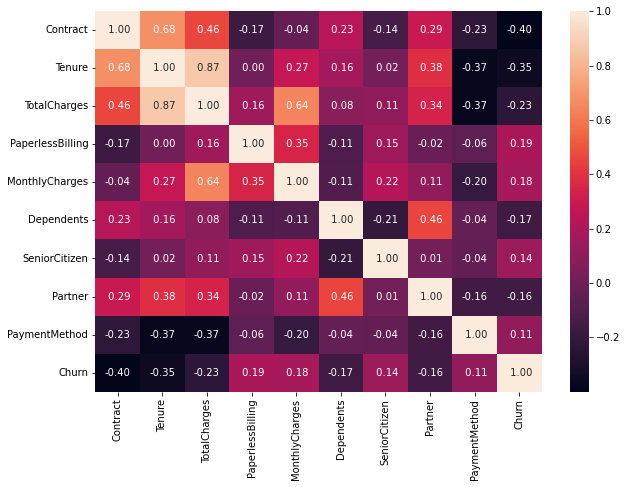

In [46]:
df_train = pd.concat([X_train, y_train], axis = 1)
corr = df_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt = ' .2f')
plt.show()

Since Tenure has a smallest correaltion with Churn we will drop Tenure 

In [47]:
X_train = X_train.drop(columns=['Tenure'])
X_test = X_test.drop(columns=['Tenure'])

In [48]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,Contract,1.781103
2,TotalCharges,3.181577
3,PaperlessBilling,1.179202
4,MonthlyCharges,2.430006
5,Dependents,1.372747
6,SeniorCitizen,1.120159
7,Partner,1.456373
8,PaymentMethod,1.170131


## Imbalanced Data Handling 

In [49]:
df['Churn'].value_counts(normalize = True)*100

No     73.534096
Yes    26.465904
Name: Churn, dtype: float64

Since the dataset have an extreme imbalanced data, we will use the imbalanced data as it is 

# Modeling 

## Logistic Regression 

In [126]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [140]:
y_pred_reg = logreg.predict(X_test)

In [142]:
cm = metrics.confusion_matrix(y_test, y_pred_reg)
print('Confusion Matrix: \n', cm)

Confusion Matrix: 
 [[892  98]
 [201 191]]


In [157]:
# classification report
from sklearn.metrics import classification_report
y_pred = rf_clf_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       990
           1       0.66      0.49      0.56       392

    accuracy                           0.78      1382
   macro avg       0.74      0.69      0.71      1382
weighted avg       0.77      0.78      0.77      1382



In [158]:
print('Precision ',precision_score(y_test, y_pred_reg)*100)
print('Recall ',recall_score(y_test, y_pred_reg)*100)
print('F1 Score ',f1_score(y_test, y_pred_reg)*100)

Precision  66.08996539792388
Recall  48.724489795918366
F1 Score  56.09397944199708


## Decision tree

In [135]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1234)
model = dt.fit(X_train, y_train)

In [138]:
y_pred_dt = dt.predict(X_test)  

In [150]:
cm = metrics.confusion_matrix(y_test, y_pred_dt)
print('Confusion Matrix: \n', cm)

Confusion Matrix: 
 [[813 177]
 [203 189]]


In [156]:
# classification report
from sklearn.metrics import classification_report
y_pred = rf_clf_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       990
           1       0.52      0.48      0.50       392

    accuracy                           0.73      1382
   macro avg       0.66      0.65      0.65      1382
weighted avg       0.72      0.73      0.72      1382



## Suport Vector Machine (SVM)

In [160]:
from sklearn import svm
svmc = svm.SVC()
model = svmc.fit(X_train, y_train)

In [161]:
# predict
y_pred_svmc = model.predict(X_test)

In [162]:
cm = metrics.confusion_matrix(y_test, y_pred_svmc)
print('Confusion Matrix: \n', cm)

Confusion Matrix: 
 [[942  48]
 [271 121]]


In [163]:
# classification report
from sklearn.metrics import classification_report
y_pred = rf_clf_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_svmc))

              precision    recall  f1-score   support

           0       0.78      0.95      0.86       990
           1       0.72      0.31      0.43       392

    accuracy                           0.77      1382
   macro avg       0.75      0.63      0.64      1382
weighted avg       0.76      0.77      0.73      1382



## Random Forest

In [129]:
# define random forest classifier model
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

In [132]:
%%time
# using random search CV
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5)
}

rf_clf_randomcv = RandomizedSearchCV(rf_clf, parameters, cv=5, 
                                     scoring='recall', n_iter=10)
rf_clf_randomcv.fit(X_train, y_train)

CPU times: total: 2.77 s
Wall time: 7.17 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': (1, 2, 3, 4, 5),
                                        'n_estimators': (10, 20, 30, 40, 50)},
                   scoring='recall')

In [133]:
# results of RandomSearchCV
cv_result = pd.DataFrame(rf_clf_randomcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score') 

,params,mean_test_score,rank_test_score
5,"{'n_estimators': 10, 'max_depth': 5}",0.376067,1
8,"{'n_estimators': 20, 'max_depth': 5}",0.373292,2
0,"{'n_estimators': 40, 'max_depth': 5}",0.364920,3
3,"{'n_estimators': 10, 'max_depth': 4}",0.278530,4
1,"{'n_estimators': 50, 'max_depth': 4}",0.271581,5
9,"{'n_estimators': 20, 'max_depth': 4}",0.270874,6
7,"{'n_estimators': 30, 'max_depth': 3}",0.159478,7
4,"{'n_estimators': 50, 'max_depth': 3}",0.146247,8
6,"{'n_estimators': 40, 'max_depth': 2}",0.052916,9
2,"{'n_estimators': 40, 'max_depth': 1}",0.000000,10


In [154]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf_clf_randomcv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=rf_clf_randomcv.best_estimator_.classes_)
print('Confusion Matrix: \n', cm)

Confusion Matrix: 
 [[914  76]
 [267 125]]


In [155]:
# classification report
from sklearn.metrics import classification_report
y_pred = rf_clf_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       990
           1       0.67      0.32      0.44       392

    accuracy                           0.76      1382
   macro avg       0.73      0.63      0.64      1382
weighted avg       0.75      0.76      0.73      1382



## Model Selection

We will use precision matrix as a comparing the evaluation value between the other models 

The highest models precision is Suport Vector Machine (SVM) with 72% and the least model is Decision Tree with 52% 